In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
from google.colab import drive
drive.mount('/content/drive')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
mixed_folder = '/content/drive/MyDrive/mix'
mix_data = datasets.ImageFolder(root = mixed_folder, transform = transform)

In [51]:
#test, train, valid with 80%, 10%, 10% accordingly.
# total_size = len(mix_data)
train_size = int(0.8 * len(mix_data) )
valid_size = int(0.1 * len(mix_data) )
test_size = len(mix_data) - train_size - valid_size
train_data, valid_data, test_data = random_split(mix_data, [train_size, valid_size, test_size])



load_train = DataLoader(train_data, batch_size=32, shuffle=True)
load_valid = DataLoader(valid_data, batch_size=32 , shuffle=False)
load_test = DataLoader(test_data, batch_size=32, shuffle=False)

model = models.resnet18(weights='IMAGENET1K_V1')
# model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


def model_train(model, load_train,load_valid, total_epoch=10):
  train_acc, valid_acc = [], []
  train_loss, valid_loss = [], []
  for epoch in range(total_epoch):
    model.train()

    total_loss, correct, total = 0,0,0

    for inputs, labels in load_train:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()

      to_return = model(inputs)
      loss = criterion(to_return, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      _, preds = torch.max(to_return, 1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()

    training_accuracy = 100 * correct/ total
    train_acc.append(training_accuracy)
    train_loss.append(total_loss / len(load_train))

    # valid now

    model.eval()

    correct_val, total_val, loss_val = 0, 0 ,0
    with torch.no_grad():
      for inputs, labels in load_valid:
        inputs, labels = inputs.to(device), labels.to(device)
        to_return = model(inputs)
        loss = criterion(to_return, labels)
        loss_val += loss.item()

        _, preds = torch.max(to_return,1)
        total_val += labels.size(0)
        correct_val += (preds==labels).sum().item()

    validation_accuracy = 100 * correct_val / total_val
    valid_acc.append(validation_accuracy)
    valid_loss.append(loss_val/len(load_valid))

    print(f"Epoch {epoch+1}/{total_epoch} -> Train Acc: {training_accuracy:.2f}%, Valid Acc: {validation_accuracy:.2f}%")
    scheduler.step()


  return train_acc, valid_acc, train_loss, valid_loss


In [52]:
train_acc, valid_acc, train_loss, valid_loss= model_train(model,load_train, load_valid)

Epoch 1/10 -> Train Acc: 78.24%, Valid Acc: 83.96%
Epoch 2/10 -> Train Acc: 88.69%, Valid Acc: 85.03%
Epoch 3/10 -> Train Acc: 93.75%, Valid Acc: 86.10%
Epoch 4/10 -> Train Acc: 96.41%, Valid Acc: 84.49%
Epoch 5/10 -> Train Acc: 97.74%, Valid Acc: 86.10%
Epoch 6/10 -> Train Acc: 98.54%, Valid Acc: 87.17%
Epoch 7/10 -> Train Acc: 99.33%, Valid Acc: 89.30%
Epoch 8/10 -> Train Acc: 99.00%, Valid Acc: 87.70%
Epoch 9/10 -> Train Acc: 99.47%, Valid Acc: 87.17%
Epoch 10/10 -> Train Acc: 99.14%, Valid Acc: 90.37%


Accuracy: 84.13%
Classification-Report:
               precision    recall  f1-score   support

         DBI       0.83      0.71      0.76        68
         SDD       0.85      0.92      0.88       121

    accuracy                           0.84       189
   macro avg       0.84      0.81      0.82       189
weighted avg       0.84      0.84      0.84       189



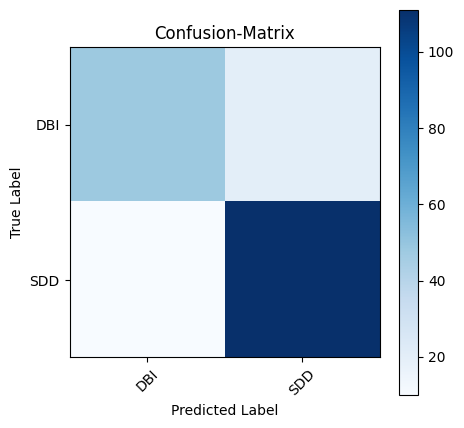

In [55]:


def evaluate(model, load_test):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in load_test:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())




    print(f'Accuracy: {100 * np.mean(np.array(all_preds) == np.array(all_labels)):.2f}%')
    #classfication
    print("Classification-Report:\n", classification_report(all_labels, all_preds, target_names=["DBI", "SDD"]))

    #confusion-matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion-Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["DBI", "SDD"], rotation=45)
    plt.yticks(tick_marks, ["DBI", "SDD"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
evaluate(model, load_test)

